# 一维搜索课程作业 青楫翔

![caption](HW1.png)

## 问题1. 求解全机阻力系数随展弦比A的函数

由于弦长沿展向不发生改变，因此雷诺数沿展向为常值，同时延展向各站位与平均气动弦长MAC相同

因此有: 
\begin{align}
c = MAC = \frac{b} A \tag{1.1}
\end{align}

从而雷诺数可改写为：
\begin{align} Re = \frac{\rho V c}\mu = \frac{\rho V\sqrt{S A}}{A\mu} \tag{1.2}\end{align}

从而当量蒙皮摩擦系数为:
\begin{align}
C_f = \frac{0.074}{Re^{0.2}} = \frac{0.074}{{(\frac{\rho V\sqrt{S A}}{A\mu})}^{0.2}} = 0.074  (\frac{\sqrt{A} \mu}{\rho V \sqrt{S}})^{0.2} \tag{1.3}
\end{align}

从而全机阻力系数为:
\begin{align}
C_D = k C_f \frac{S_{wet}}S + \frac{{C_L}^2}{\pi A e} = 0.074 k (\frac{\sqrt{A} \mu}{\rho V \sqrt{S}})^{0.2} \frac{S_{wet}}S + \frac{{C_L}^2}{\pi A e} 
\tag{1.4}
\end{align}

带入Table 1数据后，全机阻力系数1.4式可表示为:
\begin{align}
C_D(A) = 0.074 \times 1.2 \frac{17.8 \times 10^{-6}\sqrt{A}}{1.23 \times 35 \times \sqrt{11.8}} \times 2.05 + \frac{{0.3}^2}{0.96 \pi A}  = 
\frac{3.240312 \times 10^{-6}\sqrt{A}}{43.05\sqrt{11.8}} + \frac{3}{32 \pi A}
\tag{1.5}
\end{align}

## 代码表示：

In [2]:
import numpy as np
import matplotlib.pylab as plt

In [3]:
# Table 1 参数:
rho = 1.23
mu = 17.8 * 1e-6
V = 35
S = 11.8
S_wet = 2.05 * S
k = 1.2
Cl = 0.3
e = 0.96

In [4]:
def Re(A):
    '雷诺数函数'
    return (rho * V * (S * A)**0.5)/(A * mu)

def Cf(A):
    '摩擦系数函数'
    return 0.074/(Re(A)**0.2)

def Cd(A):
    '阻力系数'
    return k * Cf(A) * (S_wet/S) + (Cl**2)/(np.pi * A * e)

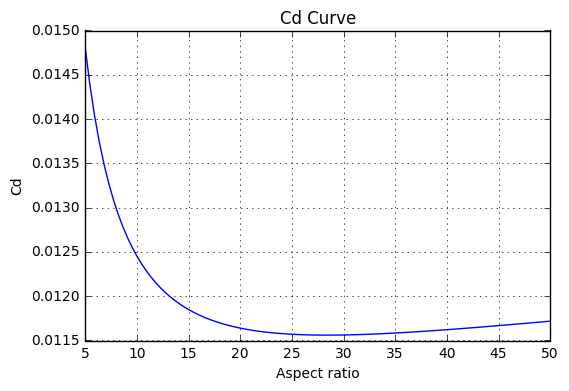

In [5]:
figure, axes = plt.subplots()
A = np.linspace(5, 50, 100, endpoint=True)
axes.plot(A, Cd(A))
plt.title('Cd Curve')
plt.xlabel('Aspect ratio')
plt.ylabel('Cd')
plt.grid()
plt.show()

## 问题2 由展弦比A优化阻力系数

### a) 黄金分割法

算法介绍:[来自谭浩强 fortran77]

![caption](GS.jpg)

Stop iterating cause stepsize: 7.473518464819603e-07 < 1e-6
Minimum found at 28.39422471994345
function evaluation times: 36
Now Cd is 0.011561


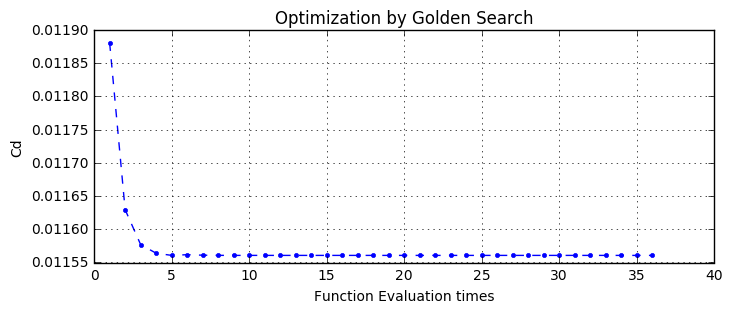

In [23]:
def search_Pattern(start, end, obj_func):
    '''
    寻找满足两高一低模式的函数范围
    '''
    assert end > start
    steps = 3
    while True:
        step_X = np.linspace(start, end, steps, endpoint=True)
        for step in range(steps-2):
            if (obj_func(step_X[step]) > obj_func(step_X[step+1])) and (obj_func(step_X[step+2]) > obj_func(step_X[step+1])):
                return (step_X[step], step_X[step+2])
        steps+= 1
        if steps > 100:
            raise ValueError('The search_Pattern cannot get a desirable bracket, sorry')
        
def is_Bracket(start, end, obj_func):
    '''
    判定start到end是否是bracket模式：注意只能应对1minimum
    '''
    try:
        if search_Pattern(start, end, obj_func):
            return True
    except ValueError:
        return False

def Golden_Search(obj_func, Xrange, is_plot=False):
    '''
    黄金分割搜索算法
    '''
    assert Xrange[-1] > Xrange[0]
    # 首先进性区间模式匹配
    start = Xrange[0]
    end = Xrange[1]
    step = end - start
    search_bracket = search_Pattern(start, end, obj_func)
    # 储存跑函数历史
    func_call_times = 0
    func_history = []
    X_history = []
    # 开始采取黄金分割求最小值
    # 注意这里采用了试探左右是否满足Bracket的方法，也可以直接用梯度指明搜索方向
    while step > 1e-6:
        step *=0.618
        func_call_times +=1
        if is_Bracket(start, start + step, obj_func):
            end = start + step
            X_history.append(end)
            func_history.append(obj_func(end))
        elif is_Bracket(end - step, end, obj_func):
            start = end - step
            X_history.append(start)
            func_history.append(obj_func(start))
        else:
            raise ValueError('Error! Goldensearch do not support!')
    
    print('Stop iterating cause stepsize: %s < 1e-6' % step)
    print('Minimum found at %s' % ((start + end)/2)) 
    print('function evaluation times: %s' %func_call_times)
    print('Now Cd is %s' % np.round(obj_func((start + end)/2),6))
    if is_plot:
        plt.figure(figsize=(8,3))
        plt.plot(np.arange(1,func_call_times + 1), func_history, '.--')
        plt.grid()
        plt.xlabel('Function Evaluation times')
        plt.ylabel('Cd')
        plt.title('Optimization by Golden Search')
        plt.show()
        return func_call_times, func_history

# 运行黄金分割算法
G_search_steps, G_func_history = Golden_Search(Cd, [5, 30], is_plot=True)
# 运行结果如下：


则由上结果知，采用黄金分隔法得到的最优展弦比约为28.394，对应阻力系数为0.011561

### b)满足强Wolfe条件的线搜索方法

In [7]:
mu_1 = 1e-4
mu_2 = 0.9

梯度计算函数:

In [8]:
def Gradient_calculator(function, X):
    '''
    计算一维函数在X点沿direction方向梯度
    direction: 1或-1,1向右-1向左
    '''
    dx = 1e-10
    return (function(X+dx)-function(X))/dx

Armijo 和 Curvature判定函数

In [9]:
def Armijo_rule(func, start_X, alpha, pk):
    '''
    判断是否满足Armijo条件
    '''
    assert alpha > 0
    if func(start_X + alpha * pk) <= (func(start_X) + mu_1 * alpha * Gradient_calculator(func, start_X) * pk):
        return True
    else:
        return False
    

def Curvature_Condition(func, start_X, alpha, pk):
    '''
    判断是否满足曲率条件:注意是强wolfe
    这里可能有问题: 由于斜率差的不多，很难满足0.9的关系(实际上差别不到0.99)，尝试增大该系数
    '''
    assert alpha > 0
    # print('Left is %s' %Gradient_calculator(func, start_X + alpha * pk))
    # print( Gradient_calculator(func, start_X))
    if abs(Gradient_calculator(func, start_X + alpha * pk) * pk) <= abs((mu_2 * Gradient_calculator(func, start_X) * pk)):
        return True
    else:
        return False
    
# 测试: 这两个函数本身是对的
# print(Armijo_rule(test, -2, 0.5, 4))
# print(Curvature_Condition(test, -2, 0.5, 4))

步长搜索函数: 

In [10]:
def step_search(obj_func,x, step_max):
    '''
    步长模糊搜索
    问题？对于一维搜索，当方向为1的时候其和函数本身的区别,没有
    说明：不需要写两方向搜索，因为梯度里面包含了正负号
    '''
    intervals = 10 # 步数间隔
    pk = -Gradient_calculator(obj_func, x) # 梯度的反方向
    alpha_max = np.round(step_max/abs(pk))# 这里当pk太小之后，搜索补偿会变得异常困难
    while True:
        # print( np.arange(0, step_max, intervals)[-1:0:-1])
        # print(np.linspace(0, alpha_max, intervals))
        for alpha in np.linspace(0, alpha_max, intervals)[-1:0:-1]:
            # print(step)
            if (Armijo_rule(obj_func, x, alpha, pk) and Curvature_Condition(obj_func, x, alpha, pk)):
                # print('alpha is %s' %alpha)
                # print('pk is %s' %pk)
                if abs(alpha * pk) < 1e-10:
                    print('Stop search: step size is less than 1e-10')
                    raise RuntimeError
                return alpha * pk
        intervals *=2
        # print('interval is %s' %intervals)
        if intervals <= 1e-2:
            # print('HERE')
            raise RuntimeError('Error!, Cannot find a feasible step')
        
# 测试
# print(step_search(test, 2, 20))

线搜索函数以及运行结果

Minimum Gradient Reached: -8.67361737988e-08
Opt interrupt cause no other sufficient decrease step can be found
Minimum Cd is: 0.011561
Optimum Aspect ratio is: 28.3332748859 




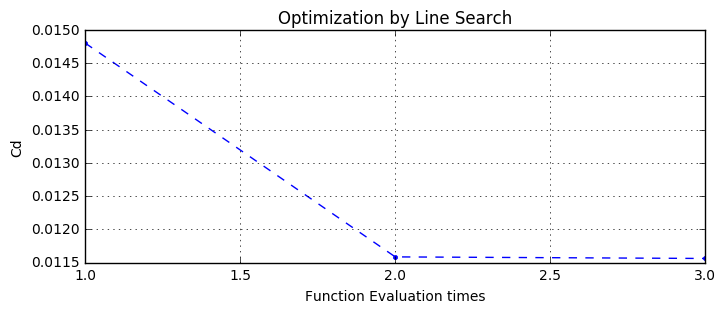

In [22]:
def line_search(obj_func, start_point=None, is_plot=False):
# 运行满足强Wolfe的梯度下降算法
    step_max = 30
    func_history = [obj_func(start_point)]
    search_steps=1
    x_history = [start_point]
    try:
        while True:
            feasible_step = step_search(obj_func, start_point, step_max)
            start_point +=feasible_step
            # print(start_point)
            search_steps +=1
            func_history.append(obj_func(start_point))
            x_history.append(start_point)
            # 进行强wolfe判定:
            # if Armijo_rule(func, se) and Curvature_Condition()
            if  abs(Gradient_calculator(obj_func, start_point)) < 1e-6:
                print('Minimum Gradient Reached: %s' % Gradient_calculator(obj_func, start_point))
                raise RuntimeError
            if search_steps >=1000:
                raise ValueError('Cannot find a opt value in 10000 steps')
                
    except RuntimeError:
        # print(x_history)
        # print(func_history)
        # print(search_steps)
        print('Opt interrupt cause no other sufficient decrease step can be found')
        print('Minimum Cd is: %s' % np.round(obj_func(start_point), 6))
        print('Optimum Aspect ratio is: %s \n'% start_point)
        print()
        if is_plot:
            # print(len(np.arange(1,search_steps + 1)))
            plt.figure(figsize=(8,3))
            plt.plot(np.arange(1,search_steps + 1), func_history, '.--')
            plt.grid()
            plt.xlabel('Function Evaluation times')
            plt.ylabel('Cd')
            plt.title('Optimization by Line Search')
            plt.show()
        return obj_func(start_point), start_point, search_steps, func_history

# C, Ar = line_search(test, start_point=-2)
# print(Ar)
# print(C)
Cd_optimize, Ar , L_search_steps, L_funchistory= line_search(Cd, start_point=5, is_plot=True)

则由上所知，当初值选取为展弦比5时，采用强Wolfe条件的线搜索得到的最优展弦比为28.33327左右，阻力系数为0.011561

# 比较两种方法的结果

由上述分析即图示结果可知，两种方法均可以找到该问题的最优解。
两个问题的收敛曲线如下图所示:

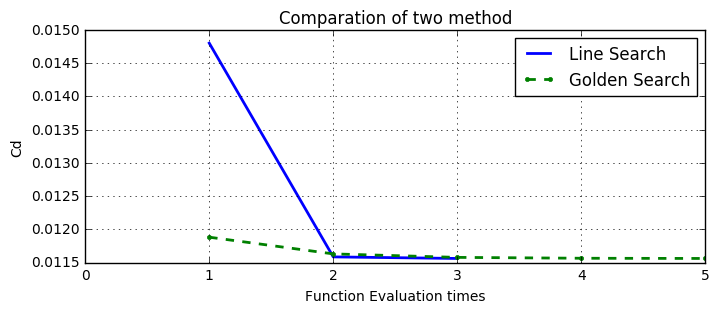

In [24]:
plt.figure(figsize=(8, 3))
plt.plot(np.arange(1,L_search_steps + 1), L_funchistory, '-', label="Line Search", linewidth=2)
plt.plot(np.arange(1,G_search_steps + 1), G_func_history, '.--',  label="Golden Search", linewidth=2)
plt.legend(loc='upper right')
plt.xlim(0, 5)
plt.grid()
plt.xlabel('Function Evaluation times')
plt.ylabel('Cd')
plt.title('Comparation of two method')
plt.show()

由上图可见，基于梯度的线搜索算法有非常陡峭的下降曲线，而黄金分割法则较为平缓，且运行次数更多（运行次数主要取决于收敛条件的设置）

Golden Search关于不同初始点的结果：

Stop iterating cause stepsize: 9.674457559637025e-07 < 1e-6
Minimum found at 28.39422745212761
function evaluation times: 35
Now Cd is 0.011561


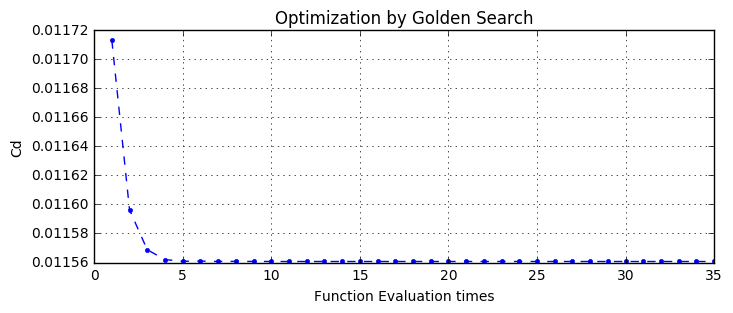

Stop iterating cause stepsize: 8.313541940265324e-07 < 1e-6
Minimum found at 28.39422624300288
function evaluation times: 37
Now Cd is 0.011561


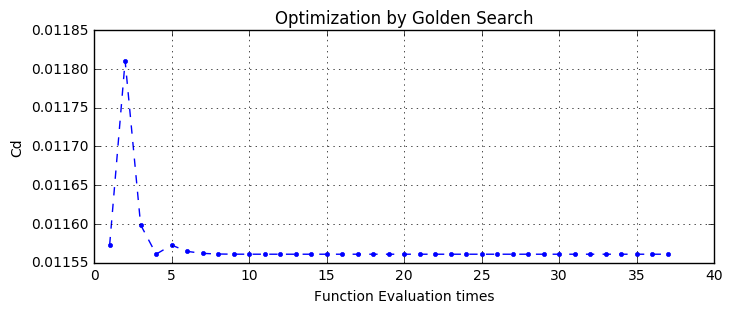

In [16]:
G_search_steps, G_func_history = Golden_Search(Cd, [10, 30], is_plot=True)
G_search_steps, G_func_history = Golden_Search(Cd, [5, 50], is_plot=True)

Line Search针对不同初始点的结果

Minimum Gradient Reached: 1.73472347598e-08
Opt interrupt cause no other sufficient decrease step can be found
Minimum Cd is: 0.011561
Optimum Aspect ratio is: 28.4210589801 




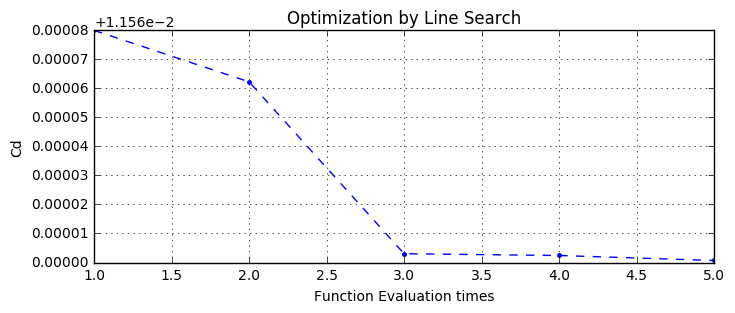

Minimum Gradient Reached: 7.1123662515e-07
Opt interrupt cause no other sufficient decrease step can be found
Minimum Cd is: 0.011561
Optimum Aspect ratio is: 28.9122827315 




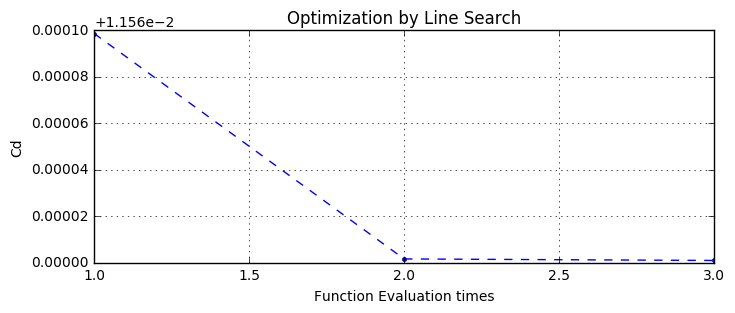

In [15]:
Cd_optimize, Ar , L_search_steps, L_funchistory= line_search(Cd, start_point=20, is_plot=True)
Cd_optimize, Ar , L_search_steps, L_funchistory= line_search(Cd, start_point=44, is_plot=True)